# Brick optimisation SPT phase calculation

Created 03/09/2024

Objectives:
* Calculate the SPT phases using brick optimsation.
* Explore validity, do the resulting MPOs output the expected state?
* When multiplied, are the resulting MPOs the same, up to the projective representation phase?
* Can caluclate the phase by comparing MPO tensor by tensor or calculating an overall trace. Which is more accurate?

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_90.h5"

In [9]:
f_name

'../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

Will need to update these based off previous work...

In [153]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

In [154]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [155]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [156]:
symmetry_actions = [
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [157]:
cases = [
    SymmetryActionWithBoundaryUnitaries(test_psi, a*50)
    for a in symmetry_actions
]

In [158]:
for c in cases:
    c.compute_svd_symmetry_action()

In [159]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [160]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [161]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [162]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [163]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [164]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [165]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [166]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [167]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [168]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [169]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [170]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [171]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [172]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [173]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM,
                           normalise=True, svd_cutoff=SVD_CUTOFF):
    U, S, VH = npc.svd(
        t,
        compute_uv=True,
        inner_labels=['vR', 'vL'],
        cutoff=svd_cutoff
    )

    # Truncate tensors:
    U = U[:, :max_inner_dim]
    S = S[:max_inner_dim]
    VH = VH[:max_inner_dim, :]

    if normalise:
        new_norm = np.sqrt(np.sum(S**2))
        S = S/new_norm

    """
    leg = VH.get_leg('vL')

    schmidt_values = npc.diag(S, leg, labels=['vL', 'vR'])
    """

    return U, S, VH

In [174]:
def split_combined_b(b, leftmost_schmidt_values,
                     max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2

    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()
    out_schmidt_values = list()

    current_left_schmidt_values = leftmost_schmidt_values

    for i, ll in enumerate(p_leg_labels[:-1]):
        t.iscale_axis(current_left_schmidt_values, axis='vL')

        tail_legs = p_leg_labels[(i+1):]
        
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=True
        )

        bl = (
            U
            .split_legs()
            .replace_label(ll, 'p')
        )
        bl.iscale_axis(1/current_left_schmidt_values, axis='vL')
        bl.iscale_axis(S, axis='vR')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        out_schmidt_values.append(S)
        current_left_schmidt_values=S

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs, out_schmidt_values

In [175]:
def split_b(b, max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return b
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [176]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [177]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [178]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [179]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [180]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [181]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [182]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, S, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim
    )

    wl.iscale_axis(S, axis='vR')

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [183]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [184]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        left_schmidt_values,
        block_width,
        block_offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    group = lambda x: group_elements(x, block_width, block_offset)
    top_grouped_bs = group(top_b_tensors)
    bottom_grouped_bs = group(bottom_b_tensors)
    grouped_schmidt_values = group(left_schmidt_values)

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]

    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    for i, u in enumerate(unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (top_combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    """
    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b
    """

    current_unitary_w_tensors = list()

    for u in unitaries:
        split_us = split_u(u, max_virtual_bond_dim=MAX_MPO_BOND_DIM)
        current_unitary_w_tensors.extend(split_us)

    if previous_mpo_w_tensors == []:
        for w in current_unitary_w_tensors:
            previous_mpo_w_tensors.append(w)
    else:
        new_mpo_w_tensors = multiply_mpos(
            previous_mpo_w_tensors,
            current_unitary_w_tensors,
            max_virtual_bond_dim=MAX_MPO_BOND_DIM
        )

        for i, w in enumerate(new_mpo_w_tensors):
            previous_mpo_w_tensors[i] = w

    return new_top_bs, new_left_schmidt_values

In [185]:
def inner_product_b_tensors(b_tensors, b_bra_tensors=None, left_environment=None,
                            right_environment=None):
    if b_bra_tensors is None:
        b_bra_tensors = b_tensors

    b = b_tensors[0]
    b_bra = b_bra_tensors[0]

    if left_environment is None:
        t = npc.tensordot(b, b_bra.conj(), [['vL',], ['vL*',]])
    else:
        t = npc.tensordot(left_environment, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    for b, b_bra in zip(b_tensors[1:], b_bra_tensors[1:]):
        t = npc.tensordot(t, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    if right_environment is None:
        out = npc.trace(t)
    else:
        out = npc.tensordot(t, right_environment, [['vR', 'vR*'], ['vL', 'vL*']])

    return out

# Get MPO tensors for each case

In [186]:
test = cases[0]

In [187]:
test.right_symmetry_index

149

In [188]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [189]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [190]:
len(bs)

25

In [191]:
symmetry_actions

[[array([[1, 0],
         [0, 1]]),
  array([[0, 1],
         [1, 0]])],
 [array([[0, 1],
         [1, 0]]),
  array([[1, 0],
         [0, 1]])],
 [array([[0, 1],
         [1, 0]]),
  array([[0, 1],
         [1, 0]])]]

## IX

In [192]:
left_environment = cases[0].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [193]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [194]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

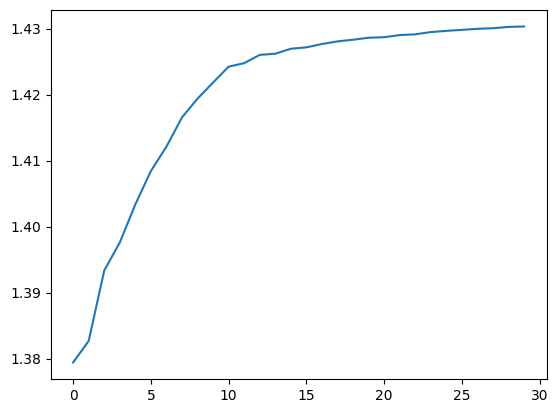

In [195]:
plt.plot(final_expectations)

In [196]:
final_expectations[-1]

1.4303073748409745

In [197]:
mpo_tensors = list()

In [198]:
ix_mpo = previous_mpo_w_tensors

In [199]:
ix_state = new_top_b_tensors

In [200]:
mpo_tensors.append(previous_mpo_w_tensors)

## XI

In [201]:
left_environment = cases[1].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [202]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [203]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

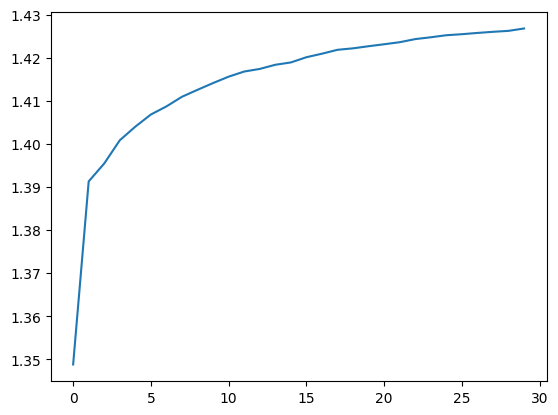

In [204]:
plt.plot(final_expectations)

In [205]:
final_expectations[-1]

1.426812464463985

In [206]:
xi_mpo = previous_mpo_w_tensors

In [207]:
xi_state = new_top_b_tensors

In [208]:
mpo_tensors.append(previous_mpo_w_tensors)

## XX

In [209]:
left_environment = cases[2].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [210]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [211]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

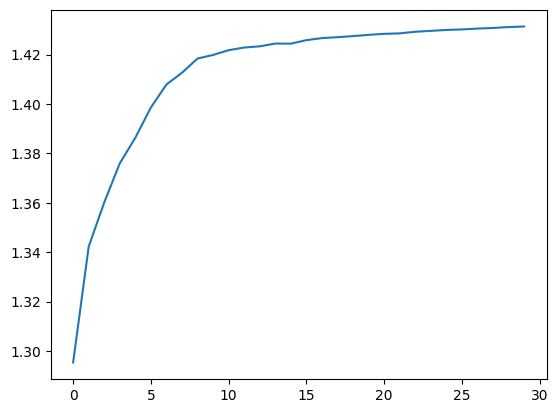

In [212]:
plt.plot(final_expectations)

In [213]:
final_expectations[-1]

1.4314127076527376

In [214]:
xx_mpo = previous_mpo_w_tensors

In [215]:
xx_state = new_top_b_tensors

In [216]:
mpo_tensors.append(previous_mpo_w_tensors)

# Compute relative phase via traces

In [217]:
mpo_1, mpo_2, mpo_3 = mpo_tensors

In [218]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [219]:
def mpo_trace_product(mpo1_tensors, mpo2_tensors):

    w1 = mpo1_tensors[0].take_slice(0, 'vL').replace_label('vR', 'vR1')
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0].take_slice(0, 'vL').replace_label('vR', 'vR2')

    t = npc.tensordot(w1, w2, [['p', 'p*'], ['p*', 'p']])
    t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = (
            npc.tensordot(t, w1, [['vR1', ], ['vL']])
            .replace_label('vR', 'vR1')
        )
        t = (
            npc.tensordot(t, w2, [['vR2', 'p', 'p*'], ['vL', 'p*', 'p']])
            .replace_label('vR', 'vR2')
        )
        t /= dim

    e = t[0,0]

    return e

In [220]:
p_ix_xi = mpo_trace_product(mpo_1, mpo_2)

In [221]:
p_ix_xi

(1.2825985803874616e-44+0j)

In [222]:
mpo_trace_product(mpo_2, mpo_3)

(-7.716251373152227e-45+0j)

In [223]:
mpo_trace_product(mpo_1, mpo_3)

(2.079168443174111e-44+0j)

In [224]:
def gauge_invariant_phase_trace(mpo1_tensors, mpo2_tensors):
    dims = [get_physical_dim(w, p_label='p') for w in mpo1_tensors]

    w1 = mpo1_tensors[0].take_slice(0, 'vL')
    w2 = mpo2_tensors[0].take_slice(0, 'vL')
    dim = get_physical_dim(w1, p_label='p')

    t = w1.replace_label('vR', 'vR1')
    t = npc.tensordot(t, w2, [['p',], ['p*',]])
    t.ireplace_label('vR', 'vR2')
    t = npc.tensordot(t, w1.conj(), [['p',], ['p*',]])
    t.ireplace_label('vR*', 'vR1*')
    t = npc.tensordot(t, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    t.ireplace_label('vR*', 'vR2*')

    t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR1', ], ['vL']])
        
        t.ireplace_label('vR', 'vR1')
        t = npc.tensordot(t, w2, [['vR2', 'p',], ['vL', 'p*',]])
        t.ireplace_label('vR', 'vR2')

        t = npc.tensordot(t, w1.conj(), [['vR1*', 'p'], ['vL*', 'p*']])
        t.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(t, w2.conj(), [['vR2*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t.ireplace_label('vR*', 'vR2*')

        t /= dim

    e = t[0,0,0,0]

    return e

In [225]:
gauge_invariant_phase_trace(mpo_1, mpo_2)

(-5.653900197570385e-79+0j)

In [226]:
gauge_invariant_phase_trace(mpo_2, mpo_3)

(-6.112965399331897e-79+0j)

In [227]:
gauge_invariant_phase_trace(mpo_1, mpo_3)

(-3.596559029706706e-79+0j)

As expected, getting too much decay in the MPOs.

# Compute relative phase by comparing w terms directly

In [228]:
import math

In [229]:
def get_canonical_form_mpo_w_tensors(mpo_w_tensors):
    """
    Function that takes in a sequence of w tensors reprenting an MPO and
    brings into right canonical form.

    Useful for comparison of MPOs as this representation is unique, so
    comparison of MPOs can be performed tensor by tensor after this
    normalisation.

    Adapted from https://github.com/tenpy/tenpy/blob/main/tenpy/networks/mps.py#L3808-L3925

    To-do:
    * Implement cutoff?
    * Implement max virtual bond dimension?
    * To renormalise or not renormalise? Check later.
    * Implement appropriate cutoff (tricky to scale though).
    """

    # Convert w tensors to having one "p" leg, like an MPS.
    # (Is this even necessary?)
    tensors = [
        w.combine_legs(['p', 'p*'])
        for w in mpo_w_tensors
    ]

    p_label = '(p.p*)'
    

    n=len(tensors)

    # First perform QR decomposition in a left to right sweep.
    # Q is orthonormal, so provides schmidt basis.
    # Multiply R into the next tensor.
    t = tensors[0]
    t = t.combine_legs(['vL', p_label])

    Q, R = npc.qr(t, inner_labels=['vR', 'vL'])
    tensors[0] = Q.split_legs()

    for i in range(1, n-1):
        t = tensors[i]
        t = (
            npc
            .tensordot(R, t, axes=['vR', 'vL'])
            .combine_legs(['vL', p_label])
        )

        Q, R = npc.qr(t, inner_labels=['vR', 'vL'])
        
        tensors[i] = Q.split_legs()

    # Now perform SVD reduction sweep from right to left.
    t = tensors[-1]
    # This is a bit of a hack. The normalisation for MPS (norm 1) is different
    # than for an MPO (for an identity, want all 1's on the appropriate
    # diagonal). Use the following factors to rescale accordingly.
    dim = get_physical_dim(t, p_label)
    rescale = math.pow(dim, 1/4)
    t = (
        npc
        .tensordot(R, t, axes=['vR', 'vL'])
        .combine_legs(['vR', p_label], qconj=-1)
    )

    singular_vals = list()
    U, S, V = npc.svd(t, inner_labels=['vR', 'vL'])
    V *= rescale
    U /= rescale

    tensors[-1] = V.split_legs()
    singular_vals.append(S)
    
    for i in range(n - 2, -1, -1):
        t = tensors[i]
        dim = get_physical_dim(t, p_label)
        rescale = math.pow(dim, 1/4)
        t = npc.tensordot(
            t,
            U.split_legs().scale_axis(S, 'vR'),
            axes=['vR', 'vL']
        )
        t = t.combine_legs(['vR', p_label], qconj=-1)
        U, S, V = npc.svd(t, inner_labels=['vR', 'vL'])
        V *= rescale
        U /= rescale
        #S = S / np.linalg.norm(S)  
        tensors[i] = V.split_legs()
        singular_vals.append(S)

    # Absorb last singular value and U matrix into the first tensor.
    # Both of these should be scalars.
    tensors[0] *= U[0, 0]*S[0]
    singular_vals[-1] /= S[0]
    tensors = [t.split_legs(-1) for t in tensors]
    singular_vals = singular_vals[::-1]

    return tensors, singular_vals

In [230]:
canonical_mpo_tensors = [
    get_canonical_form_mpo_w_tensors(mpo)[0]
    for mpo in mpo_tensors
]

In [231]:
symmetry_actions = ['IX', 'XI', 'XX']

In [232]:
from itertools import combinations

In [233]:
list(combinations(symmetry_actions, 2))

[('IX', 'XI'), ('IX', 'XX'), ('XI', 'XX')]

In [234]:
mpo_pairs = [
    (mpo_tensors[(i+1)%3], mpo_tensors[(i+2)%3])
    for i in range(3)
]

In [235]:
mpo_pair_products = [
    multiply_mpos(m1, m2)
    for m1, m2 in mpo_pairs
]

In [236]:
canonical_mpo_pair_products = [
    get_canonical_form_mpo_w_tensors(mpo)[0]
    for mpo in mpo_pair_products
]

In [237]:
pair, single = canonical_mpo_pair_products[0], canonical_mpo_tensors[0]

In [238]:
pair[0]

<npc.Array shape=(1, 4, 2, 2) labels=['vL', 'vR', 'p', 'p*']>

In [239]:
single[0]

<npc.Array shape=(1, 4, 2, 2) labels=['vL', 'vR', 'p', 'p*']>

In [240]:
X_pair = pair[0].to_ndarray()

In [241]:
X_single = single[0].to_ndarray()

In [242]:
X_pair

array([[[[-1.80010471e-13+0.j, -7.07228707e-15+0.j],
         [-1.41904185e-14+0.j,  2.25896748e-13+0.j]],

        [[ 1.34746148e-13+0.j,  6.59255452e-15+0.j],
         [ 1.09012992e-14+0.j,  1.08266437e-13+0.j]],

        [[-1.68040776e-15+0.j, -4.22123843e-15+0.j],
         [ 2.33607586e-14+0.j, -3.74446512e-18+0.j]],

        [[-7.27171918e-16+0.j,  1.22636540e-14+0.j],
         [ 2.16369853e-15+0.j, -5.95966552e-17+0.j]]]])

In [243]:
X_single/X_pair

array([[[[-1.53817091e-08-0.j, -1.05493605e-08-0.j],
         [-7.50994998e-09-0.j,  1.08409406e-08-0.j]],

        [[ 7.38960548e-09-0.j,  9.50772340e-10-0.j],
         [-6.87400752e-09+0.j, -1.03701080e-08+0.j]],

        [[-5.33050231e-09-0.j,  3.92683375e-08+0.j],
         [ 2.22930150e-08-0.j,  7.40834979e-06+0.j]],

        [[ 6.69077455e-09+0.j,  2.79037543e-08-0.j],
         [ 5.01411282e-08-0.j,  1.61846997e-07+0.j]]]])